# Richard Marcelain 
## HW 13
## 11/23/2020

## Grade 
6/6 - Great job! Very nice job talking over your results and providing discussion of your graphs. I also like how you generated your print statements, its very easy to understand what is being printed out. 

In the future I would suggest:
- Add a block to the top of your code with all of the file reads and where you can set all of your global variables. For example the forecast date would be somethign that could be good to pull out at the top as a user variable. 
- Try defining your functions in a separate file.
- Consider breaking up your blocks of code with some more narration along the way. Sometimes you already have  this in comments in your code blocks and it could easily be pulled out into your md. 


### 1. Purpose of notebook
The purpose of this notebook is to share a browser-based application of python code which is used to predict future streamflow of the Verde River in Arizona.  This document workflow contains codes available to modify and share, text documentation, and code outputs (i.e. images).

### 2. How forecasts are generated
Forecasts are generated using an autoregression (AR) model with a two-week lag.  The AR model is built using historical Verde River stream gage data retreived from USGS: https://waterdata.usgs.gov/az/nwis/uv?site_no=09506000.  The AR model is trained with a robust 200 week sample with intentionally low values at the start and end points.  This decision was to influence results towards lower values, because the model results are naturaly shifted towards positive values due to its very high peaks, and midlly low troughs.  Addtionally, the previous 20-year streamflow average is subtracted from the current year to represent the late and low streamflow values currently being experienced.

### 3. Forecast discussion
Initially my forecasts were poor, but throughout the semester they have improved.  My predictions were top of class a couple weeks, and I believe my own error in entering the forecast values caused me to miss at least one more top spot.  Building the autoregression model was a big improvement that reduced the randomness of my predictions.  Understanding how the AR model worked to produce results, helped inform my decision to nudge it towards desired results.

### 4. Map
Plot a map of Verde River Gage with 4 overlays:  USGS Stream gages, watershed boundaries, rivers, and basemap.  The Verde River stream gage near Camp Verde, AZ is used for the AR model.

In [1]:
# Load Python Libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
from shapely.geometry import Point
import contextily as ctx
import os
import json 
import urllib.request as req
import urllib
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.linear_model import LinearRegression

In [6]:
# Dataset 1:  gage locations
# Gauges II USGS stream gauge dataset: https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder
# Reading it using geopandas
file = os.path.join('../data','gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# Variable containing only Arizona gages
gages_az=gages[gages['STATE']=='AZ']

# Isolate verde river gage (via station ID) and project onto gages map
verde_stid = gages_az[gages_az['STAID'] == '09506000']
verde_gage = verde_stid.to_crs(gages_az.crs)

In [27]:
# Dataset 2:  watershed boundaries
# Watersheds dataset:  https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products
# Watershed boundaries for the lower colorado 
file = os.path.join('../data','WBD_15_HU2_GDB.gdb')
HUC6 = gpd.read_file(file, layer="WBDHU6")

# Project lower colorado watersheds onto gages map
HUC6_project = HUC6.to_crs(gages_az.crs)

# Isolate verde river watershed boundary and project onto gages map
HUC6_verde = HUC6[HUC6['name'] == 'Verde']
HUC6_verde_project = HUC6_verde.to_crs(gages_az.crs)

In [28]:
# Dataset 3:  rivers
# Rivers dataset:  https://repository.arizona.edu/handle/10150/188710
file = os.path.join('../data','az_hydro_routesNAD83.shp')
fiona.listlayers(file)

# Define Arizona rivers and project onto gages map
az_rivers = gpd.read_file(file)
az_proj_rivers = az_rivers.to_crs(gages.crs)

# Isolate verde river and project onto gages map
river_verde = az_rivers[az_rivers['NAME'] == 'Verde River']
river_verde_project = river_verde.to_crs(gages_az.crs)

In [24]:
# Function: plot variables and data onto a single map
def plot_map(dcolumn='DRAIN_SQKM', categorical=False,
              legend=True, markersize=45, cmap='RdBu'):   
    fig, ax = plt.subplots(figsize=(10, 10))       

    # Zoom in plot to focus on verde river
    xlim = ([-1700000, -1200000])
    ylim = ([1150000, 1700000])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Data points and layers (inc. basemap)
    #gages_az.plot(ax=ax, label='Stream Gages', color='darkgreen', edgecolor='white', markersize=50, zorder=5)
    HUC6_project.boundary.plot(ax=ax, label='HUC6 Boundary', color=None, edgecolor='black', linewidth=1, zorder=1, alpha=0.5)
    HUC6_verde_project.boundary.plot(ax=ax, label='Verde Watershed', color=None, edgecolor='black', linewidth=2, zorder=2)
    #az_proj_rivers.plot(ax=ax, label='Rivers', color='blue', zorder=3, alpha=0.4)
    river_verde_project.plot(ax=ax, label='Verde River', linewidth=2, color='blue', zorder=4)
    verde_gage.plot(ax=ax, label='Verde River Gage', color='red', edgecolor='white', marker='v', markersize=250, zorder=6)
    ctx.add_basemap(ax, crs=gages_az.crs, url=ctx.providers.OpenTopoMap, zorder=0, alpha=0.5)

    # Plot axis/data titles
    ax.set_title('Verde River Stream Gage', fontsize=20)
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.legend()  
    return fig, ax

<ipython-input-24-b31e26e57f39>:19: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, crs=gages_az.crs, url=ctx.providers.OpenTopoMap, zorder=0, alpha=0.5)


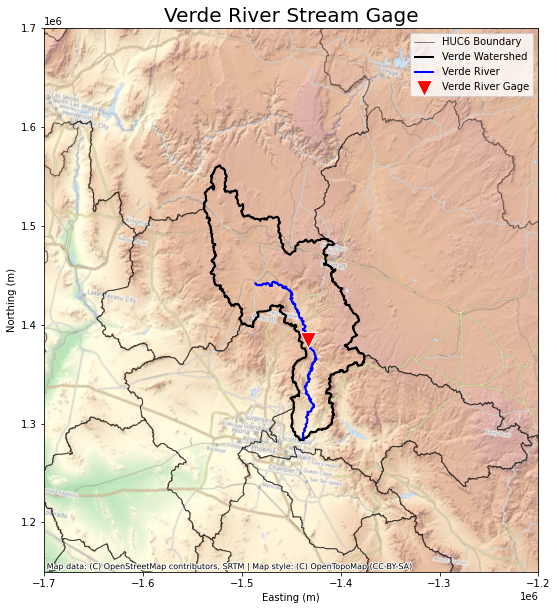

In [51]:
# Run function to plot map
fig, ax = plot_map(gages_az)  

### Map Discussion
This figure shows the city of Phoenix, AZ at the bottom center of the map.  Verde River (blue) stream gage (red) is shown within a watershed boundary (bold black) along with surrounding watersheds (black) in Arizona.


### 5. Plots
Create two line plots:  Precipitation (daily) and Stream flow (weekly)
1. Precipitation plot uses NCEP North American Regional Reanalysis (NARR) dataset retrieved from: NOAA PSL website at https://psl.noaa.gov/data/gridded/data.narr.monolevel.html.
2. Streamflow data uses USGS discharge gaga data retrived from: https://waterdata.usgs.gov/az/nwis/uv?site_no=09506000.

Precipitation and stream flow are linked through natural physical processes.  Precipitation data should help inform stakeholder on how much streamflow to anticipate.

In [18]:
# 1. Precipitation Data
# File path
data_path = os.path.join('../data','prate.2020.nc')
# Read in the dataset as an x-array
dataset = xr.open_dataset(data_path)
# Extract Phoenix precipitation datapoint and define as a variable
precip = dataset["prate"][:,93,157]
print(precip.shape)

(305,)


C:\Users\Richard\miniconda3\envs\hastools\lib\site-packages\xarray\conventions.py:492: SerializationWarning: variable 'prate' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


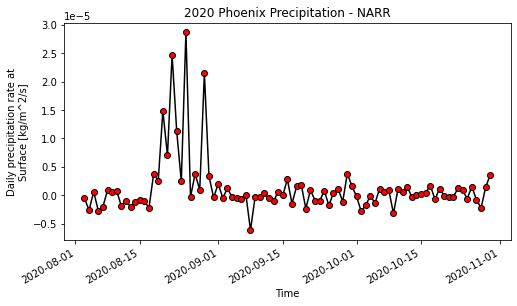

In [19]:
# Make a timeseries plot
f, ax = plt.subplots(figsize=(12, 6))
precip[215:304].plot.line(hue='lat',
                    marker="o",
                    ax=ax,
                    color="black",
                    markerfacecolor="red")                    
ax.set(title="2020 Phoenix Precipitation - NARR")
f.set_size_inches(8,4)

### Plot Discussion
This figure shows the daily precipitation rate at surface in Phoenix, AZ for August 1, 2020 through November 1, 2020.  There appears to be a very dry year occuring in Phoenix with rain only precipitating in August. 

In [64]:
# 2. Streamflow data
# Retrieve Streamflow data 

# Location and time variables 
site = '09506000'
start = '1989-01-01'
end = '2020-11-21'

# URL modified with variables
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + \
      site + "&referred_module=sw&period=&begin_date=" + start + \
      "&end_date=" + end
data = pd.read_table(url, skiprows=30,
                     names=['agency_cd', 'site_no',
                            'datetime', 'flow', 'code'],
                     parse_dates=['datetime'])

# Expand data to different time dimensions including weekly (most important)
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).day
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Convert to weekly data
flow_weekly = data.resample("W", on='datetime').mean()

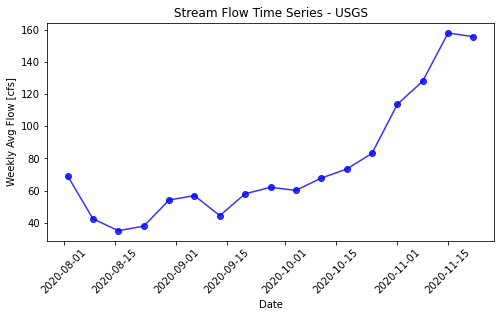

In [69]:
# Streamflow Time Series
fig, ax = plt.subplots()
ax.plot(flow_weekly['flow'].tail(17), '-b',marker="o", alpha=.8)
ax.set(title="Stream Flow Time Series - USGS", xlabel="Date",
        ylabel="Weekly Avg Flow [cfs]")

plt.xticks(visible=True, rotation=45)
fig.set_size_inches(8,4)

### Plot Discussion
This figure shows the weekly discharge at the Verde River stream gage for August 1, 2020 through November 15, 2020.  This dataset extents further than the precipitation data, and it indicates considerable precipitation occuring in early November.  While there is an increase in stream flow following the August precipitation (shown in previous plot), there may be a better data grid to represent precipitation affecting the Verde River stream gage.

### 6. Function
The function below is the autoregression (AR) model previously discussed.  It was used to predict most of the 16-week semester streamflow values of Verde River stream gage.

In [94]:
# Function to predict weekly flow values using AR model results and previous flow data
def predictions(lastweek_flow,model):
    ''''
    This function will be call on at the end of AR model section of code.

    The previous week's flow along with intercept and coefficient
    values obtained from AR model are used to precict two weeks of streamflow.

    The adjustment takes the average October flow over the last two decades and subtracts
    the 2019 October average flow.  This is to adjust the prediction by the anomalous 
    low flow year values which the datasite is experiencing.

    '''
    adjustment = (np.mean(flow_weekly[(flow_weekly['year']>2000) & (flow_weekly['month']==11)]) - np.mean(flow_weekly[(flow_weekly['year']==2020) & (flow_weekly['month']==11)]))
    prediction = np.zeros(16)
    prediction[0] = (model.intercept_ + model.coef_ * lastweek_flow) - adjustment['flow']
    for i in range (1,16):
        prediction[i] = (model.intercept_ + model.coef_ * prediction[i-1]) - adjustment['flow']
    return prediction

In [95]:
# Building an autoregressive model (steps 1-4)
# Step 1: Setup the arrays to build model using lagged weekly (1 & 2) times
flow_weekly['flow_tm1'] = flow_weekly['flow'].shift(1)
flow_weekly['flow_tm2'] = flow_weekly['flow'].shift(2)

# Step 2: Robust modern dataset to train the AR model starting and ending at low flow values to influence results
train = flow_weekly[1400:1600][['flow', 'flow_tm1', 'flow_tm2']]
test = flow_weekly[1600:][['flow', 'flow_tm1', 'flow_tm2']]

# Step 3: Fit a linear regression model 
model = LinearRegression()
x=train['flow_tm1'].values.reshape(-1,1)  
y=train['flow'].values
model.fit(x,y)

# Step 4: Add variable for latest weekly flow data which will be used in function
october2020_flow = flow_weekly[['flow']].tail(2).round(1)
lastweek_flow = october2020_flow.values[0]

In [111]:
# Run AR-based function to produce remaining forecast weeks
flow_prediction = predictions(lastweek_flow,model)

# Print forecast values
print('Regression based forecasts:')
print('1 Week: ',flow_prediction[0].round(1), "cfs")
print('2 Week: ',flow_prediction[1].round(1), "cfs")

Regression based forecasts:
1 Week:  153.1 cfs
2 Week:  149.8 cfs


### 7. Forecasts
Week 13 - 11/23/2020

#### 2-Week Forecasts 
* 1 Week:  153.1 cfs
* 2 Week:  149.8 cfs

#### All 16 Weeks
* Week 1:   54.09 cfs
* Week 2:   56.83 cfs
* Week 3:   44.36 cfs
* Week 4:   57.97 cfs
* Week 5:   62.00 cfs
* Week 6:   60.09 cfs
* Week 7:   67.77 cfs
* Week 8:   73.31 cfs
* Week 9:   83.13 cfs
* Week 10:  113.7 cfs
* Week 11:  126.5 cfs
* Week 12:  129.54 cfs
* Week 13:  148.1 cfs
* Week 14:  153.1 cfs
* Week 15:  149.8 cfs
* Week 16:  159.76 cfs